In [11]:
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, _check_length_scale

import scipy.optimize
from scipy.spatial.distance import cdist, pdist, squareform
import numpy as np
import torch

import matplotlib.pyplot as plt

from torch_geometric.data import Data

# Gaussian Process

In [140]:
def compute_vector_distance(A,B,ord=1):
    """
    res[i,j] = ||A[i,:] - B[j,:]||_ord
    """
    assert len(A.shape) == 2, A.shape
    assert len(B.shape) == 2, B.shape
    assert A.shape[1] == B.shape[1], (A.shape, B.shape)
    m, d = A.shape
    n, d = B.shape

    aug_A = np.einsum("mdj,ndj->mnd", A[...,np.newaxis],np.ones((n,d,1)))
    aug_B = np.einsum("ndj,mdj->mnd", B[...,np.newaxis],np.ones((m,d,1)))
    res = np.power(np.sum(np.power(np.abs(aug_A - aug_B),ord),axis = -1),1/ord)
    return res

compute_vector_distance(np.array([[0,1],[1,2]]),np.array([[0,3]]),ord=2)

array([[2.        ],
       [1.41421356]])

In [28]:
class MyRBF(RBF):
    """Radial basis function kernel (aka squared-exponential kernel).

    Minimal changes for entering the distance function as an attribute
    """

    def __init__(self, length_scale=1.0, length_scale_bounds=(1e-5, 1e5),dist_metric:str="sqeuclidean"):
        """
        Parameters
        ----------
        - dist_metric : (str)
            Check scipy documentation on pdist or cdist for the possible dist_metric values.
            Careful: if the kernel is anysotrope (length_scale is a vector of size > 1), the formula of of the kernel puts d(x/length_scale,y/length_scale) which is different from  d(x,y)/length_scale**2 in for most dist_metric (except sq Euclidian dist)
        """
        self.length_scale = length_scale
        self.length_scale_bounds = length_scale_bounds
        self.dist_metric = dist_metric


    def __call__(self, X, Y=None, eval_gradient=False):
        """Return the kernel k(X, Y) and optionally its gradient.

        Parameters
        ----------
        X : ndarray of shape (n_samples_X, n_features)
            Left argument of the returned kernel k(X, Y)

        Y : ndarray of shape (n_samples_Y, n_features), default=None
            Right argument of the returned kernel k(X, Y). If None, k(X, X)
            if evaluated instead.

        eval_gradient : bool, default=False
            Determines whether the gradient with respect to the log of
            the kernel hyperparameter is computed.
            Only supported when Y is None.

        Returns
        -------
        K : ndarray of shape (n_samples_X, n_samples_Y)
            Kernel k(X, Y)

        K_gradient : ndarray of shape (n_samples_X, n_samples_X, n_dims), \
                optional
            The gradient of the kernel k(X, X) with respect to the log of the
            hyperparameter of the kernel. Only returned when `eval_gradient`
            is True.
        """
        X = np.atleast_2d(X)
        length_scale = _check_length_scale(X, self.length_scale)

        if Y is None:
            dists = pdist(X / length_scale, metric=self.dist_metric)
            K = np.exp(-0.5 * dists)
            # convert from upper-triangular matrix to square matrix
            K = squareform(K)
            np.fill_diagonal(K, 1)
        else:
            if eval_gradient:
                raise ValueError("Gradient can only be evaluated when Y is None.")
            dists = cdist(X / length_scale, Y / length_scale, metric=self.dist_metric )
            K = np.exp(-0.5 * dists)

        if eval_gradient:
            if self.hyperparameter_length_scale.fixed:
                # Hyperparameter l kept fixed
                return K, np.empty((X.shape[0], X.shape[0], 0))
            elif not self.anisotropic or length_scale.shape[0] == 1:
                K_gradient = (K * squareform(dists))[:, :, np.newaxis]
                return K, K_gradient
            elif self.anisotropic:
                # We need to recompute the pairwise dimension-wise distances
                K_gradient = (X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2 / (
                    length_scale**2
                )
                K_gradient *= K[..., np.newaxis]
                return K, K_gradient
        else:
            return K

In [169]:
class MyRBFGaussianProcessRegressor():
    def __init__(self,
                 dim_out:int, 
                 lengthscale:float = 1.0,
                 length_scale_bounds:float = (1e-5,1e5),
                 dist_metric:str = "sqeuclidean"):
        self.dim_out = dim_out
        self.gpr = GaussianProcessRegressor(
            kernel=MyRBF(length_scale=lengthscale,
                         length_scale_bounds=length_scale_bounds,
                         dist_metric=dist_metric), 
                         random_state=0,
                         normalize_y=True)

    def get_n_free_params(self):
        return 1
    

    def predict(self, # reorder parameters
                node_attr:torch.Tensor,
                x_pred_mask:torch.Tensor,
                x_base_mask:torch.Tensor,
                y_base:torch.Tensor,
                **kwargs): # transform into node_attr = graph.x
        """Careful compared to other models, node_attr should be the representational values of x, not the information they carry for y
        """
        x_pred = node_attr[x_pred_mask].numpy()
        x_base = node_attr[x_base_mask].numpy()
        y_base = y_base.numpy()

        self.gpr.fit(X = x_base, y = y_base)
        y_pred = self.gpr.predict(X = x_pred)

        if len(y_pred.shape) == 1 and len(y_base.shape) == 2:
            y_pred = y_pred[...,np.newaxis] 

        return torch.Tensor(y_pred)

    def mae_error_function(self, 
                           y_true:torch.Tensor,
                           node_attr:torch.Tensor,
                           x_pred_mask:torch.Tensor,
                           x_base_mask:torch.Tensor,
                           y_base:torch.Tensor,
                           **kwargs):
        y_pred = self.predict(
                node_attr = node_attr,
                x_pred_mask = x_pred_mask,
                x_base_mask = x_base_mask,
                y_base = y_base)
        mae_loss = torch.nn.L1Loss()
        mae_error = mae_loss(y_pred, y_true)
        mae_error = mae_error.detach()
        return mae_error
    
    def mse_error_function(self, 
                           y_true:torch.Tensor,
                           node_attr:torch.Tensor,
                           x_pred_mask:torch.Tensor,
                           x_base_mask:torch.Tensor,
                           y_base:torch.Tensor,
                           **kwargs):
        y_pred = self.predict(
                node_attr = node_attr,
                x_pred_mask = x_pred_mask,
                x_base_mask = x_base_mask,
                y_base = y_base)
        mae_loss = torch.nn.MSELoss()
        mae_error = mae_loss(y_pred, y_true)
        mae_error = mae_error.detach()
        return mae_error
    
    def _store_params(self):
        pass

    def _restore_params(self):
        pass
    
    def fit(self,
            dataset,
            val_dataset = None, 
            bounds = [(1e-5,1e5)], # need to give more values if bias
            **kwargs):
        batch_graph = next(iter(dataset))
        is_validation_present = hasattr(batch_graph,"val_mask")

        assert len(bounds) == self.get_n_free_params(), (f"len(bounds) = {len(bounds)} != {self.get_n_free_params()} = self.get_n_free_params()")

        def obj_func(theta,
                     y_true, 
                     node_attr,
                     x_pred_mask, 
                     x_base_mask,
                     y_base):
            self.gpr.kernel.length_scale = theta[0]

            # MSE as loss function because of its link to log-marginal-likelihood
            mse_loss = self.mse_error_function(
                y_true = y_true,
                node_attr = node_attr,
                x_pred_mask = x_pred_mask,
                x_base_mask = x_base_mask,
                y_base = y_base)
            return mse_loss.numpy() 

        history = {"lengthscale_opt":[],"func_min":[],"val_mae":[],"val_mse":[]}

        for batch_graph in dataset:            
            if hasattr(batch_graph,"base_mask"):
                base_mask = batch_graph.base_mask
            else:
                base_mask = torch.ones(batch_graph.num_nodes).to(torch.bool)
                base_mask[batch_graph.train_mask] = False

                if is_validation_present:
                    base_mask[batch_graph.val_mask] = False
            
            self._store_params()
            opt_res = scipy.optimize.dual_annealing(
                lambda theta: obj_func(theta=theta,
                                       y_true = batch_graph.y[batch_graph.train_mask],
                                       node_attr = batch_graph.x,
                                       x_pred_mask = batch_graph.train_mask,
                                       x_base_mask = base_mask,
                                       y_base = batch_graph.y[base_mask]
                                       ), 
                bounds=np.array(bounds)
            )
            self._restore_params()

            params_opt, func_min = opt_res.x, opt_res.fun
            history["lengthscale_opt"].append(float(params_opt[0]))
            history["func_min"].append(float(func_min))

            if is_validation_present:
                init_lengthscale = self.gpr.kernel.length_scale # no copy.copy because there is no "effet de bord" from float
                self.gpr.kernel.length_scale = history["lengthscale_opt"][-1]
                val_mae = self.mae_error_function(
                    y_true = batch_graph.y[batch_graph.val_mask],
                    x_pred_mask = batch_graph.val_mask,
                    x_base_mask = base_mask,
                    y_base = batch_graph.y[base_mask]
                )
                val_mse = self.mse_error_function(
                    y_true = batch_graph.y[batch_graph.val_mask],
                    x_pred_mask = batch_graph.val_mask,
                    x_base_mask = base_mask,
                    y_base = batch_graph.y[base_mask]
                )
                self.gpr.kernel.length_scale = init_lengthscale
                history["val_mae"].append(float(val_mae))
                history["val_mse"].append(float(val_mse))
            
            else:

                history["val_mae"].append(np.nan)
                history["val_mse"].append(np.nan)
        
        # restore last best fit
        self.gpr.kernel.length_scale = history["lengthscale_opt"][-1]
        return history



In [110]:
kernel = RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,
        random_state=0)

In [111]:
X, y = make_friedman2(n_samples=500, noise=0, random_state=0)
X_pred, y_pred = make_friedman2(n_samples=500, noise=0, random_state=4)

kernel = RBF(length_scale=1.0,length_scale_bounds="fixed")
gpr = GaussianProcessRegressor(kernel=kernel,
        random_state=0).fit(X, y)
print(gpr.score(X, y))
print(gpr.predict(X[:2,:], return_std=True),y[:2])
print(gpr.predict(X_pred[:2,:], return_std=True),y_pred[:2])
print(gpr.kernel.length_scale)

1.0
(array([781.91445761, 518.4431357 ]), array([1.00000004e-05, 1.00000004e-05])) [781.91445769 518.44313575]
(array([9.30036391e+01, 8.33828419e-11]), array([0.94946666, 1.        ])) [996.48885986 472.49488028]
1.0


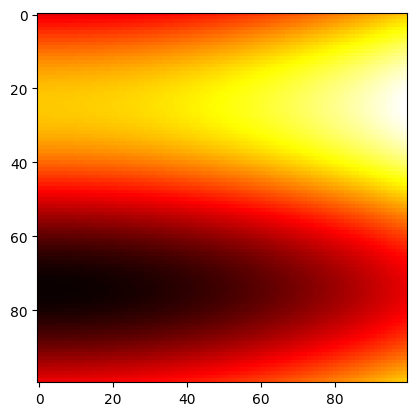

In [112]:
def my_problem(X):
    return X[...,1]**2 + np.sin(2*np.pi*X[...,0])

X = np.meshgrid(np.linspace(0,1,100),np.linspace(0,1,100))
X = np.stack(X).T
y = my_problem(X)

plt.imshow(y, cmap='hot', interpolation='nearest')
plt.show()

In [113]:
_X = X.reshape((X.shape[0]*X.shape[1],X.shape[-1]))
print(_X.shape)

_y = y.reshape((y.shape[0]*y.shape[1],1))
print(_y.shape)

(10000, 2)
(10000, 1)


In [114]:
_X_train.shape

(1000, 2)

In [1]:
n_samples_base = 5
base_kept_ids = np.random.choice(np.arange(_X.shape[0]),size=n_samples_base,replace=False)
_X_base = _X[base_kept_ids]
_y_base = _y[base_kept_ids]

n_samples_train = 1000
train_kept_ids = np.random.choice(list(set(list(np.arange(_X.shape[0]))) - set(base_kept_ids)), size=n_samples_train, replace=False)
_X_train = _X[train_kept_ids]
_y_train = _y[train_kept_ids]

new_X = np.concat([_X_base,_X_train],axis=0)
new_y = np.concat([_y_base,_y_train],axis=0)

base_mask = torch.zeros(new_X.shape[0]).to(bool)
base_mask[:_X_base.shape[0]] = True
train_mask = torch.zeros(new_X.shape[0]).to(bool)
train_mask[_X_base.shape[0]:] = True
complete_train_mask = train_mask.clone()

graph = Data(
    x = torch.Tensor(new_X),
    y = torch.Tensor(new_y),
    x_names = ["x","y"],
    y_names = ["f(x,y)"],
    train_mask = train_mask,
    base_mask = base_mask,
    complete_train_mask = complete_train_mask
)

gpr = MyRBFGaussianProcessRegressor(dim_out=1,lengthscale=4,length_scale_bounds="fixed")
y_pred = gpr.predict(
    node_attr=graph.x,
    x_pred_mask=torch.ones(graph.x.size(0)).to(bool),
    x_base_mask = graph.base_mask,
    y_base = graph.y[graph.base_mask]
)

NameError: name 'np' is not defined

In [148]:
y_pred.size(),graph.y.size()

(torch.Size([1003, 1]), torch.Size([1003, 1]))

In [149]:
y_pred[graph.base_mask],graph.y[graph.base_mask]

(tensor([[1.0357],
         [1.1295],
         [0.7840]]),
 tensor([[1.0357],
         [1.1295],
         [0.7840]]))

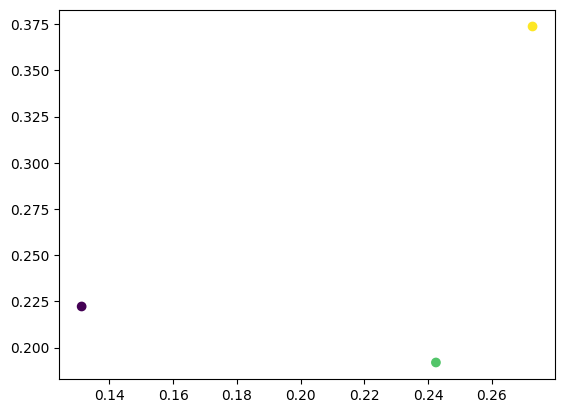

In [150]:
plt.scatter(graph.x[graph.base_mask,0],graph.x[graph.base_mask,1],c=graph.y[graph.base_mask])
plt.show()

In [151]:
graph.train_mask.size(),graph.x.size()

(torch.Size([1003]), torch.Size([1003, 2]))

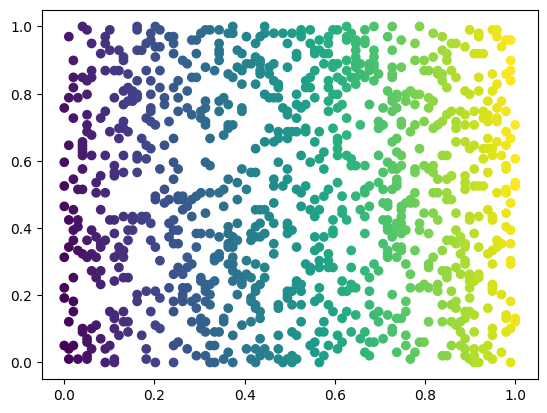

In [152]:
plt.scatter(graph.x[graph.train_mask,0],graph.x[graph.train_mask,1],c=y_pred[graph.train_mask])
plt.show()

## Recovery

In [153]:
graph.y = y_pred

In [158]:
gpr = MyRBFGaussianProcessRegressor(dim_out=1,lengthscale=1,length_scale_bounds="fixed")
y_pred = gpr.predict(
    node_attr=graph.x,
    x_pred_mask=torch.ones(graph.x.size(0)).to(bool),
    x_base_mask = graph.base_mask,
    y_base = graph.y[graph.base_mask]
)

y_pred - graph.y

tensor([[ 0.0000e+00],
        [ 0.0000e+00],
        [ 0.0000e+00],
        ...,
        [-9.7203e-04],
        [-1.3351e-04],
        [-2.3835e-01]])

In [163]:
gpr.fit(
    dataset=[graph],
    bounds=[(1e-1,100)]
)

{'lengthscale_opt': [3.9961853005108225],
 'func_min': [1.1743387373641667e-09],
 'val_mae': [nan],
 'val_mse': [nan]}

# Geometric Kernels

In [7]:
import numpy as np
# Import the geometric_kernels backend.
import geometric_kernels
# Import a space and an appropriate kernel.
from geometric_kernels.spaces import Hypersphere
from geometric_kernels.kernels import MaternGeometricKernel

# Create a manifold (2-dim sphere).
hypersphere = Hypersphere(dim=2)

# Define 3 points on the sphere.
xs = np.array([[0., 0., 1.], [0., 1., 0.], [1., 0., 0.]])

# Initialize kernel.
kernel = MaternGeometricKernel(hypersphere)
params = kernel.init_params()
params["nu"] = np.array([5/2])
params["lengthscale"] = np.array([1.])

# Compute and print out the 3x3 kernel matrix.
print(np.around(kernel.K(params, xs), 2))

INFO (geometric_kernels): Numpy backend is enabled. To enable other backends, don't forget to `import geometric_kernels.*backend name*`.
INFO (geometric_kernels): We may be suppressing some logging of external libraries. To override the logging policy, call `logging.basicConfig`.


[[1.   0.36 0.36]
 [0.36 1.   0.36]
 [0.36 0.36 1.  ]]


IMPORTANT: The graph must be undirected and have nonnegative weights. The edges of this graph define the geometry: you expect that nodes connected by edges with large weights to be more correlated than nodes connected by edges with small weights.

## Basic

In [8]:
# Import a backend, we use numpy in this example.
import numpy as np

# Import the geometric_kernels backend.
import geometric_kernels

# Note: if you are using a backend other than numpy,
# you _must_ uncomment one of the following lines
# import geometric_kernels.tensorflow
# import geometric_kernels.torch
# import geometric_kernels.jax

# Import a space and an appropriate kernel.
from geometric_kernels.spaces import Graph
from geometric_kernels.kernels import MaternGeometricKernel

# We use networkx to visualize graphs
import networkx as nx

import matplotlib as mpl
import matplotlib.pyplot as plt    

### Defining a space

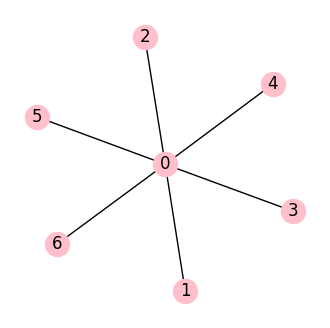

In [9]:
nx_graph = nx.star_graph(6)
pos = nx.spring_layout(nx_graph)

plt.figure(figsize=(4,4))
nx.draw(nx_graph, node_color = 'pink', ax=plt.gca(), pos=pos)
nx.draw_networkx_labels(nx_graph,pos=pos,labels={k:str(k) for k in np.arange(nx_graph.number_of_nodes())})
plt.show()

The normalize_laplacian parameter controls whether to use the eigenvectors of the unnormalized Laplacian or the symmetric normalized Laplacian as features (see the optional Theory section below for details). 

In [10]:
graph = Graph(np.array(nx.to_numpy_array(nx_graph)), normalize_laplacian=False)
graph

### Defining a Kernel

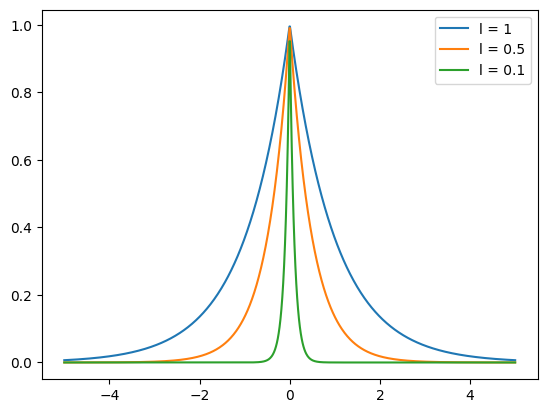

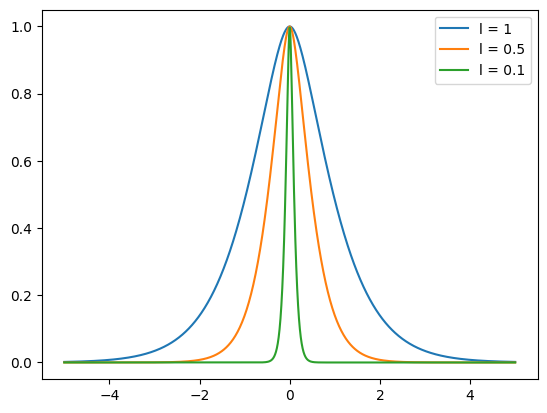

In [11]:
def matern_12(x0,x1, l=1):
    term = 1/l * np.linalg.norm(x0-x1,ord=2,axis=-1)
    return np.exp(-term)

def matern_32(x0,x1, l=1):
    term = np.sqrt(3)/l * np.linalg.norm(x0-x1,ord=2,axis=-1)
    return (1+term)*np.exp(-term)

for l in [1,0.5,0.1]:
    x0 = 0
    x1 = np.linspace(-5,5,1000)[...,np.newaxis]
    plt.plot(x1,matern_12(x0,x1,l),label=f"l = {l}")
plt.legend()
plt.show()

for l in [1,0.5,0.1]:
    x0 = 0
    x1 = np.linspace(-5,5,1000)[...,np.newaxis]
    plt.plot(x1,matern_32(x0,x1,l),label=f"l = {l}")
plt.legend()
plt.show()




In [12]:
kernel = MaternGeometricKernel(graph)

params = kernel.init_params()
print('params:', params)

params: {'nu': array([inf]), 'lengthscale': array([1.])}


In [13]:
kernel

In [14]:
params["lengthscale"] = np.array([3])
params_32  = params.copy()
params_inf = params.copy()
del params
params_32["nu"]  = np.array([3/2])
params_inf["nu"] = np.array([np.inf])

print("params_32",params_32)
print("params_inf",params_inf)

params_32 {'nu': array([1.5]), 'lengthscale': array([3])}
params_inf {'nu': array([inf]), 'lengthscale': array([3])}


### Evaluating Kernels on Random Inputs

In [15]:
key = np.random.RandomState(1234)
key, xs = graph.random(key, 3)
print(xs)

kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_inf = kernel.K(params_inf, xs, xs)
print("kernel_mat_inf\n",kernel_mat_inf)

[[3]
 [6]
 [5]]
kernel_mat_inf
 [[ 1.61284682 -0.12748651 -0.12748651]
 [-0.12748651  0.75234683  0.73301348]
 [-0.12748651  0.73301348  0.75234683]]


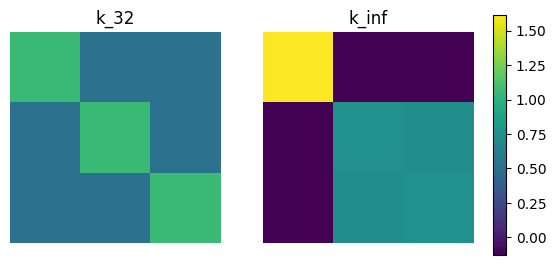

In [16]:
# find common range of values
minmin = np.min([np.min(kernel_mat_32), np.min(kernel_mat_inf)])
maxmax = np.max([np.max(kernel_mat_32), np.max(kernel_mat_inf)])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cmap = plt.get_cmap('viridis')

ax1.imshow(kernel_mat_32, vmin=minmin, vmax=maxmax, cmap=cmap)
ax1.set_title('k_32')
ax1.set_axis_off()

ax2.imshow(kernel_mat_inf, vmin=minmin, vmax=maxmax, cmap=cmap)
ax2.set_title('k_inf')
ax2.set_axis_off()

# add space for color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin, vmax=maxmax))
fig.colorbar(sm, cax=cbar_ax)

plt.show()

### Visualizing kernels

In [17]:
base_point = 1 # choosing a fixed node for kernel visualization
other_points = np.arange(graph.num_vertices)[:, None]
print(other_points)

[[0]
 [1]
 [2]
 [3]
 [4]
 [5]
 [6]]


In [18]:
values_32  = kernel.K(params_32,  np.array([[base_point]]),
                              other_points).flatten()
values_inf = kernel.K(params_inf, np.array([[base_point]]),
                              other_points).flatten()
print(values_32)
print(values_inf)

[0.60580813 1.05878229 0.52351292 0.52351292 0.52351292 0.52351292
 0.52351292]
[ 0.24861905  1.69889681 -0.04143651 -0.04143651 -0.04143651 -0.04143651
 -0.04143651]


In [19]:
# Get prior variances k(*, *) for * in nodes:
variance_32  = kernel.K_diag(params_32,  other_points)
variance_inf = kernel.K_diag(params_inf, other_points)
print(variance_32)
print(variance_inf)

[0.64730624 1.05878229 1.05878229 1.05878229 1.05878229 1.05878229
 1.05878229]
[0.24861905 1.69889681 0.32209684 1.61284682 1.61284682 0.75234683
 0.75234683]


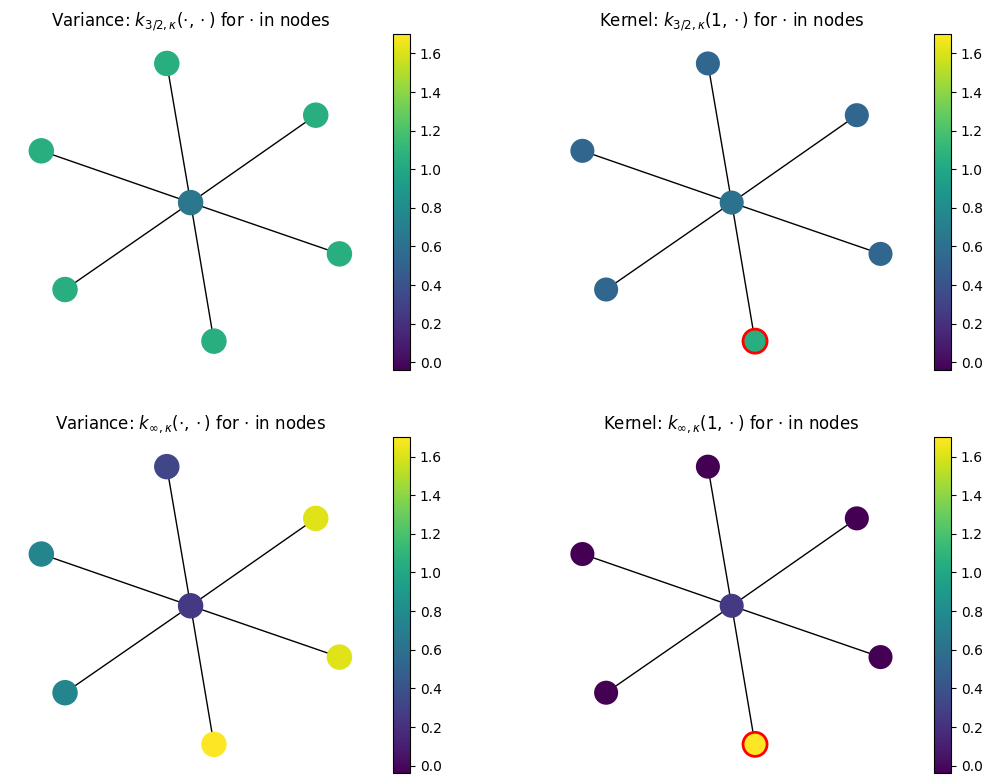

In [20]:
cmap = plt.get_cmap('viridis')

# Set the colorbar limits:
vmin = min(0.0, values_32.min(), values_inf.min())
vmax = max(1.0, variance_32.max(), variance_inf.max())


# Red outline for the base_point:
edgecolors = [(0, 0, 0, 0)]*graph.num_vertices
edgecolors[base_point] = (1, 0, 0, 1)

# Save graph layout so that graph appears the same in every plot
kwargs = {'pos': pos}


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12.8, 9.6))

# Plot variance 32
nx.draw(nx_graph, ax=ax1, cmap=cmap, node_color=variance_32,
        vmin=vmin, vmax=vmax, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax1)
ax1.set_title('Variance: $k_{3/2, \kappa}(\cdot, \cdot)$ for $\cdot$ in nodes')

# Plot kernel values 32
nx.draw(nx_graph, ax=ax2, cmap=cmap, node_color=values_32,
        vmin=vmin, vmax=vmax, edgecolors=edgecolors,
        linewidths=2.0, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax2)
ax2.set_title('Kernel: $k_{3/2, \kappa}($%d$, \cdot)$ for $\cdot$ in nodes' % base_point)

# Plot variance inf
nx.draw(nx_graph, ax=ax3, cmap=cmap, node_color=variance_inf,
        vmin=vmin, vmax=vmax, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax3)
ax3.set_title('Variance: $k_{\infty, \kappa}(\cdot, \cdot)$ for $\cdot$ in nodes')

# Plot kernel values inf
nx.draw(nx_graph, ax=ax4, cmap=cmap, node_color=values_inf,
        vmin=vmin, vmax=vmax, edgecolors=edgecolors,
        linewidths=2.0, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax4)
ax4.set_title('Kernel: $k_{\infty, \kappa}($%d$, \cdot)$ for $\cdot$ in nodes' % base_point)


plt.show()

Note that the variance changes from node to node on this graph.

For example, for the unnormalized Laplacian, the variance is related to the expected return time of a random walk: how many steps, on average, does it take a particle randomly walking over the graph and starting in node x to return back to node x. For the center node, the expected return time is 2. For other nodes, it is always higher. Hence the variance in the center is lower than in the other nodes. This argument is inspired by Borovitskiy et al. (2021).

In [21]:
print('Variance in the center node is %0.2f,' % variance_32[0],
      'variance in the side nodes is %0.2f.' % variance_32[1],
      'The average variance is %0.2f.' % np.mean(variance_32))

Variance in the center node is 0.65, variance in the side nodes is 1.06. The average variance is 1.00.


## Feature Maps and Sampling    

### Defining a Feature Map

In [22]:
from geometric_kernels.kernels import default_feature_map

feature_map = default_feature_map(kernel=kernel)

In [23]:
# xs are random points from above
_, embedding = feature_map(xs, params_32)

print('xs (shape = %s):\n%s' % (xs.shape, xs))
print('')
print('embedding (shape = %s):\n%s' % (embedding.shape, embedding))

kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_32_alt = np.matmul(embedding, embedding.T)

print('')
print('||k(xs, xs) - phi(xs) * phi(xs)^T|| =', np.linalg.norm(kernel_mat_32 - kernel_mat_32_alt))

xs (shape = (3, 1)):
[[3]
 [6]
 [5]]

embedding (shape = (3, 7)):
[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]

||k(xs, xs) - phi(xs) * phi(xs)^T|| = 2.2377342288765063


### Efficient Sampling using Feature Maps

In [24]:
from geometric_kernels.sampling import sampler

sample_paths = sampler(feature_map, s=2)

# introduce random state for reproducibility (optional)
# `key` is jax's terminology
key = np.random.RandomState(seed=1234)

# new random state is returned along with the samples
key, samples = sample_paths(xs, params_32, key=key)

print('Two samples evaluated at the xs are:')
print(samples)

Two samples evaluated at the xs are:
[[0 2]
 [0 2]
 [0 2]]


/home/julien-rsbrg/venv/venv_semantic_to_liking/lib/python3.10/site-packages/lab/numpy/random.py:30: UserWarning: Casting random number of type float to type integer.
  warnings.warn("Casting random number of type float to type integer.")


### Visualizing Samples

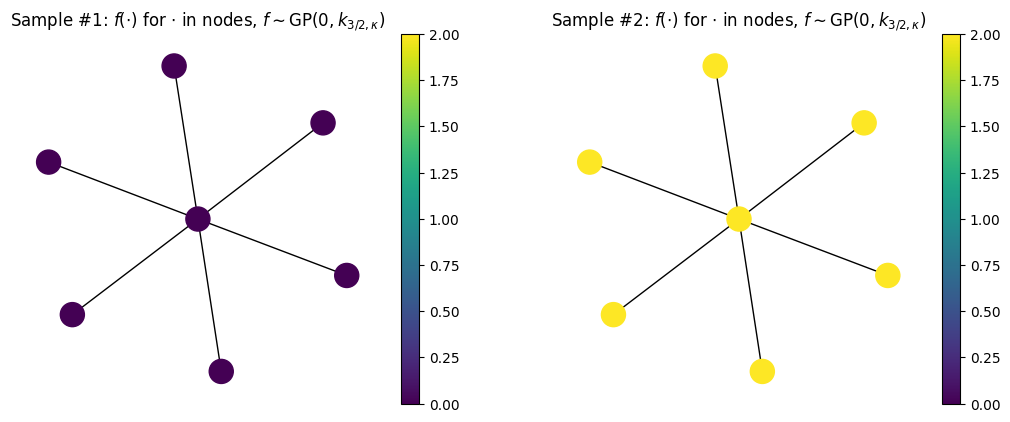

In [25]:
key = np.random.RandomState(seed=1234)
key, samples = sample_paths(other_points, params_32, key=key)

sample1 = samples[:, 0]
sample2 = samples[:, 1]

cmap = plt.get_cmap('viridis')

# Set the colorbar limits:
vmin = min(sample1.min(), sample2.min())
vmax = max(sample1.max(), sample2.max())

# Save graph layout so that graph appears the same in every plot
kwargs = {'pos': pos}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))

# Plot sample #1
nx.draw(nx_graph, ax=ax1, cmap=cmap, node_color=sample1,
        vmin=vmin, vmax=vmax, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax1)
ax1.set_title('Sample #1: $f(\cdot)$ for $\cdot$ in nodes, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')


# Plot sample #2
nx.draw(nx_graph, ax=ax2, cmap=cmap, node_color=sample2,
        vmin=vmin, vmax=vmax, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax2)
ax2.set_title('Sample #2: $f(\cdot)$ for $\cdot$ in nodes, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')

plt.show()

## Prediction

In [26]:
# problem definition

x_base = np.array([[1]])
y_base = np.array([[1]])

x_pred = np.arange(0,graph.num_vertices)[...,None]

# pred 

kernel_mat_32 = kernel.K(params_32, x_pred, x_base)
kernel_mat_32_base = kernel.K(params_32, x_base, x_base)

values_32 = (kernel_mat_32 / (np.diag(kernel_mat_32_base) + 1e-10)) @ y_base # shouldn't take everything, only contact (* adj_matrix)
print("values_32:",values_32)

kernel_mat_inf = kernel.K(params_inf, x_pred, x_base)
kernel_mat_inf_base = kernel.K(params_inf, x_base, x_base)

values_inf = (kernel_mat_inf / (np.diag(kernel_mat_inf_base) + 1e-10)) @ y_base
print("values_inf:",values_inf)


values_32: [[0.5721744 ]
 [1.        ]
 [0.49444812]
 [0.49444812]
 [0.49444812]
 [0.49444812]
 [0.49444812]]
values_inf: [[ 0.14634146]
 [ 1.        ]
 [-0.02439024]
 [-0.02439024]
 [-0.02439024]
 [-0.02439024]
 [-0.02439024]]


vmin,vmax -0.02439024390100272 0.9999999999411383


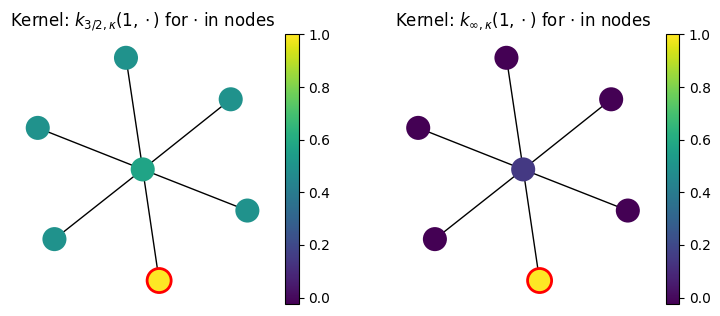

In [27]:
cmap = plt.get_cmap('viridis')

# Set the colorbar limits:
vmin = min(values_32.min(), values_inf.min())
vmax = max(values_32.max(), values_inf.max())
print("vmin,vmax",vmin,vmax)


# Red outline for the base_point:
edgecolors = [(0, 0, 0, 0)]*graph.num_vertices
edgecolors[base_point] = (1, 0, 0, 1)

# Save graph layout so that graph appears the same in every plot
kwargs = {'pos': pos}


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3.5))

# Plot kernel values 32
nx.draw(nx_graph, ax=ax1, cmap=cmap, node_color=values_32,
        vmin=vmin, vmax=vmax, edgecolors=edgecolors,
        linewidths=2.0, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax1)
ax1.set_title('Kernel: $k_{3/2, \kappa}($%d$, \cdot)$ for $\cdot$ in nodes' % base_point)

# Plot kernel values inf
nx.draw(nx_graph, ax=ax2, cmap=cmap, node_color=values_inf,
        vmin=vmin, vmax=vmax, edgecolors=edgecolors,
        linewidths=2.0, **kwargs)
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax2)
ax2.set_title('Kernel: $k_{\infty, \kappa}($%d$, \cdot)$ for $\cdot$ in nodes' % base_point)


plt.show()